## NCAA March Madness

### Preliminary Analysis of First Round Upsets

The objective of the [Skatsbetball Tournament 2018](http://thisisstatistics.org/home-2/statsketball/) [Upset Challenge](http://thisisstatistics.org/home-2/statsketball/statsketball-guidelines/) is to predict the 32 winners of the First Round in the [2018 NCAA Men's Division I Basketball Tournament](https://www.ncaa.com/march-madness).

In order to do well in this contest, you need to decide how many upsets to pick in the first round. After all, the purpose of the seeding is to make it more likely that the higher-seeded teams make it to the later rounds. If the tournament committee does it's job well, the higher-seeded teams should be measurably better than their first round opponents.

Picking upsets is also important for filling out a regular March Madness bracket. To avoid having upsets bust your bracket, it can help to have a sense of the reasonable number of upsets to pick, and which seeds are more likely to fall early in the tournament.

One reasonable way to assess the likelihood of first round upsets is to see how many have occurred historically. This notebook examines all first round NCAA tournament results from 1985 through 2017 to see how the higher seeds have fared.

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [3]:
from pathlib import Path

In [4]:
PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / 'data' / 'scraped'
DATA_DIR.mkdir(exist_ok=True, parents=True)
OUTPUT_DIR = PROJECT_DIR / 'data' / 'prepared'
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

#### Loading the Data

We previously obtained historical NCAA tournament data from the [Washington Post's NCAA Tournament site](https://apps.washingtonpost.com/sports/apps/live-updating-mens-ncaa-basketball-bracket/search/) and saved it as a CSV file.

Let's load in the data and prepare it for analysis.

In [5]:
def load_tournament_games():
    filename = 'games-washpost.csv'
    csvfile = DATA_DIR.joinpath(filename)
    df = pd.read_csv(csvfile)
    df.columns = df.columns.str.rstrip()
    return df.rename(columns={'year': 'Year', 'round': 'Round',})

In [6]:
load_tournament_games().head()

,Year,Round,seed1,team1,score1,seed2,team2,score2
0,2017,1,5,Notre Dame,60,12,Princeton,58
1,2017,1,4,West Virginia,86,13,Bucknell,80
2,2017,1,5,Virginia,76,12,UNC Wilmington,71
3,2017,1,4,Florida,80,13,East Tennessee State,65
4,2017,1,1,Gonzaga,66,16,South Dakota State,46


#### Determining Winners, Losers and Upsets

We are going to create various new columns in our `DataFrame` to allow us to analyze the upsets in various ways.

We will use the `pandas` `apply()` method to add columns with the correct information for each row of data.

In [7]:
def winner(row):
    if row['score1'] > row['score2']:
        return row['team1']
    else:
        return row['team2']

In [8]:
def loser(row):
    if row['score1'] > row['score2']:
        return row['team2']
    else:
        return row['team1']

In [9]:
def winner_seed(row):
    if row['score1'] > row['score2']:
        return row['seed1']
    else:
        return row['seed2']    

In [10]:
def loser_seed(row):
    if row['score1'] > row['score2']:
        return row['seed2']
    else:
        return row['seed1']

In [11]:
def higher_seed(row):
    return min(row['seed1'], row['seed2'])

In [12]:
def winner_score(row):
    return max(row['score1'], row['score2'])   

In [13]:
def loser_score(row):
    return min(row['score1'], row['score2'])   

Now we can put everything together in one function to load and format the data.

In [14]:
def tournament_games():
    df = load_tournament_games()
    df['HigherSeed'] = df.apply(higher_seed, axis=1)
    df['Winner'] = df.apply(winner, axis=1)
    df['Loser'] = df.apply(loser, axis=1)
    df['WinnerSeed'] = df.apply(winner_seed, axis=1)
    df['LoserSeed'] = df.apply(loser_seed, axis=1)
    df['WinnerScore'] = df.apply(winner_score, axis=1)
    df['LoserScore'] = df.apply(loser_score, axis=1)
    df = df.drop(columns=[
        'seed1',
        'team1',
        'score1',
        'seed2',
        'team2',
        'score2',
    ])
    winner_cols = [col for col in df.columns if 'Winner' in col]
    loser_cols = [col for col in df.columns if 'Loser' in col]
    cols = ['Year', 'Round', 'HigherSeed'] + winner_cols + loser_cols
    return df[cols].sort_values(['Year', 'Round']).reset_index(drop=True)

In [15]:
games = tournament_games()
games.shape

(2079, 9)

In [16]:
games.head()

,Year,Round,HigherSeed,Winner,WinnerSeed,WinnerScore,Loser,LoserSeed,LoserScore
0,1985,1,6,Boston College,11,55,Texas Tech,6,53
1,1985,1,7,Alabama,7,50,Arizona,10,41
2,1985,1,2,Virginia Commonwealth,2,81,Marshall,15,65
3,1985,1,3,Illinois,3,76,Northeastern,14,57
4,1985,1,6,Georgia,6,67,Wichita State,11,59


This `DataFrame` is useful for analyzing later-round games as well, so let's save it for future analysis.

In [17]:
filename = 'game_history-washpost-1985_2017.csv'
csvfile = OUTPUT_DIR.joinpath(filename)
games.to_csv(csvfile, index=False)

#### First Round Results

We will focus only on the first round in this notebook.

In [18]:
round1 = games[games['Round'] == 1].copy()
len(round1)

1056

In [19]:
len(round1['Year'].unique())

33

In [20]:
1056/33

32.0

We have 33 years of NCAA Tournament data, with 32 games played in the first round each year.

Now let's see what proportion of first round games each seed has won in the first round. Remember, there are 4 regions, with 16 seeds in each region.

In [21]:
round1['WinnerSeed'].value_counts() / (4*33)

1     1.000000
2     0.939394
3     0.840909
4     0.803030
5     0.643939
6     0.628788
7     0.613636
8     0.507576
9     0.492424
10    0.386364
11    0.371212
12    0.356061
13    0.196970
14    0.159091
15    0.060606
Name: WinnerSeed, dtype: float64

If you [look at Wikipedia](https://en.wikipedia.org/wiki/NCAA_Division_I_Men%27s_Basketball_Tournament#First_and_Second_Rounds), you'll see identical frequency data for first round victories as of the time I wrote this.

We can turn these in "upset" frequencies by subtracting them from 1.

In [22]:
1 - round1['WinnerSeed'].value_counts() / (4*33)

1     0.000000
2     0.060606
3     0.159091
4     0.196970
5     0.356061
6     0.371212
7     0.386364
8     0.492424
9     0.507576
10    0.613636
11    0.628788
12    0.643939
13    0.803030
14    0.840909
15    0.939394
Name: WinnerSeed, dtype: float64

#### Don't Pick Sixteenth Seeds

Notice that a first seed has never lost in the first round, which is why the sixteenth seed doesn't appear in the above results.


Since a first seed has never lost in the first round, we are going to exclude it from further analysis.

Of course, if the NCAA Tournament continues with the same format for another 30, 50 or 100 years, eventually a sixteenth seed will advance. But unless you think the tournament committee has made a huge mistake in the seeding, don't pick the sixteenth seed to advance.

#### Eight and Ninth Seeds

At the other end of the spectrum, notice that the eight and ninth seed first round win frequencies are both roughly 50%.

This means that the 8-9 matchups look like coin tosses in the historical data, with only a slight bias in favor of the eighth seed.

#### Upsets by Seed

Let's filter out the 1-16 matchups and define an upset as anytime the higher seed loses. Of course, it's not really correct to view a ninth seed victory as an upset, since those games historically look like toss-ups.

In [23]:
def filter_upsets(row):
    return (
        (row['HigherSeed'] == row['LoserSeed']) &
        (row['HigherSeed'] in range(2, 9))
    )

In [24]:
round1['Upset'] = round1.apply(lambda row: filter_upsets(row), axis=1)

In [25]:
upsets = round1[round1['Upset'] == True]

In [26]:
upsets.groupby(['HigherSeed'])['Year'].count()

HigherSeed
2     8
3    21
4    26
5    47
6    49
7    51
8    65
Name: Year, dtype: int64

#### Upsets per Year

The above counts give the total number of upsets over the 33-year historical period, grouped by seed. Let's look at the historical data grouped by year instead.

In [27]:
upsets.groupby(['Year']).size().describe()

count    33.000000
mean      8.090909
std       2.454125
min       3.000000
25%       7.000000
50%       8.000000
75%      10.000000
max      13.000000
dtype: float64

So, on average there are 8 upsets per year. However, what we really want is the distribution of upsets by seed within a given year.

In [28]:
upsets_by_year = upsets.pivot_table(
    index='Year',
    columns='HigherSeed',
    values='WinnerSeed', aggfunc='count'
).fillna(0)

In [29]:
upsets_by_year.describe()

HigherSeed,2,3,4,5,6,7,8
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.242424,0.636364,0.787879,1.424242,1.484848,1.545455,1.969697
std,0.501890,0.652791,0.599874,0.867118,1.003781,0.904534,1.185455
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
75%,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000
max,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,4.000000


Let's check that the above pivot table ties back to the original win frequency data. If we sum up the number of upsets by higher seed and divide by the total number of historical games, we should get back the upset frequencies we computed above.

In [30]:
upsets_by_year.sum() / (4*33)

HigherSeed
2    0.060606
3    0.159091
4    0.196970
5    0.356061
6    0.371212
7    0.386364
8    0.492424
dtype: float64

Since a picture is worth a thousand words, let's visualize the number of first round upsets by seed, by year.

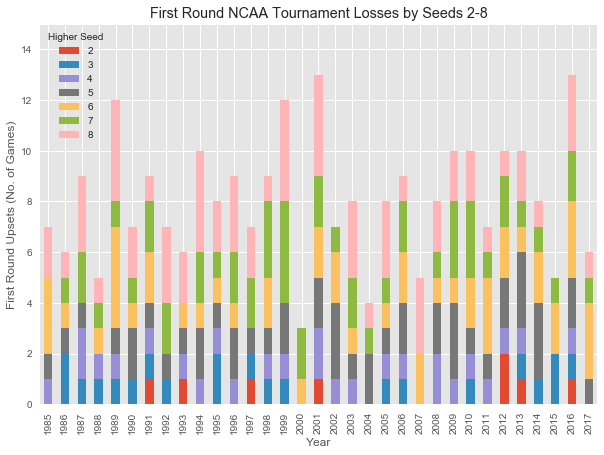

In [31]:
fix, ax = plt.subplots(figsize=(10, 7))
upsets_by_year.plot(ax=ax, kind='bar', stacked=True)
ax.set_ylim(0, 15)
ax.set_xlabel('Year')
ax.set_ylabel('First Round Upsets (No. of Games)')
ax.set_title('First Round NCAA Tournament Losses by Seeds 2-8')
ax.legend(title='Higher Seed')
plt.show()

To chart makes it easy to understand the overall variability of upsets from year to year, both in terms of the overall number and by seed.

We can also summarize the above data in a small table.

In [32]:
upset_freq = upsets_by_year.apply(pd.value_counts).fillna(0).astype(int).reset_index(drop=True).transpose()
upset_freq

,0,1,2,3,4
HigherSeed,,,,,
2,26,6,1,0,0
3,15,15,3,0,0
4,10,20,3,0,0
5,4,15,10,4,0
6,5,13,10,4,1
7,3,14,12,3,1
8,3,10,9,7,4


This frequency table will be useful for making specific decisions about how many first round upsets to pick.

Since each row sums to 33, we can divide each value by 33 to estimate a probability distribution for the number of upsets by seed per year.

In [33]:
upset_freq.sum(axis=1)

HigherSeed
2    33
3    33
4    33
5    33
6    33
7    33
8    33
dtype: int64

In [34]:
upset_freq / 33

,0,1,2,3,4
HigherSeed,,,,,
2,0.787879,0.181818,0.030303,0.000000,0.000000
3,0.454545,0.454545,0.090909,0.000000,0.000000
4,0.303030,0.606061,0.090909,0.000000,0.000000
5,0.121212,0.454545,0.303030,0.121212,0.000000
6,0.151515,0.393939,0.303030,0.121212,0.030303
7,0.090909,0.424242,0.363636,0.090909,0.030303
8,0.090909,0.303030,0.272727,0.212121,0.121212


### How Many Upsets to Pick?

In summary, here are some preliminary conclusions based upon the above data and analysis. We'll try to develop a more precise framework in a later post.

#### Second Seed Upsets

Although a second seed does occasionally lose in the first round (and in 2012, two second seeds lost), it's rare. Don't pick the fifteenth seed to advance, unless you have a very strong view that the tournament committee has made a mistake in either the second or the fifteenth seeds. If you do, however, the historical data say you're unlikely to be correct.

#### Third and Fourth Seed Upsets

Things are more promising for calling upsets in the third and fourth seed games. On average, there is at least one upset among these 8 first round games in a given year. There is often one upset in each of the third and fourth seed games, but there are rarely more than 2 upsets overall in these 8 games.

The data suggest that you should pick an upset among the third and fourth seeds as a group. You should also try hard to identify another upset, for the seed which you didn't pick in the first upset. In other words, if you already picked a third seed upset, try to pick a fourth seed upset, and vice versa.

#### Fifth Seed Upsets

Most tournaments have featured at least 1 fifth seed upset in the first round, and many years have two. You should definitely look to pick one upset. It's probably reasonable to pick a second upset in this category if you have strong views about the matchup.

#### Sixth and Seventh Seed Upsets

The data tell a similar story for the sixth and seventh seed games. You should try to pick one sixth seed and one seventh seed upset in the first round. If you have strong views about particular matchups, it's reasonable to look for additional potential upsets. However, you should keep in mind that the overall number of upsets (excluding the 8-9 games) rarely exceeds 8 in a given year.

In summary, among the second through seventh seeds, the historical data suggest you should aim to pick 5 or 6 upsets, and venture beyond that only if you have high conviction about a few additional games.

#### The 8-9 Matchups

As mentioned above, a ninth seed victory isn't really an upset. There are years where all the eighth seeds advance, and years where all the ninth seeds advance.

For regular bracket selection, your goal is just to get as many teams as possible from your bracket into the second round. For that purpose, you should analyze the 8-9 games strictly on the merits of the matchups. In contrast, the Statsketball Upset Challenge awards bonus points for correctly picking an upset, defined as the lower seed beating the higher seed. With the possibility of bonus points, you have somewhat greater incentive to pick the ninth seed, even if the game is a true toss-up. We'll study the impact of Upset Challenge bonus points in a future post.